In [1]:
import os
import wandb
import logging
from pytorch_lightning.utilities.seed import seed_everything
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from DLIP.utils.loading.initialize_wandb import initialize_wandb
from DLIP.utils.loading.load_data_module import load_data_module
from DLIP.utils.loading.load_model import load_model
from DLIP.utils.loading.load_trainer import load_trainer
from DLIP.utils.loading.merge_configs import merge_configs
from DLIP.utils.loading.parse_arguments import parse_arguments
from DLIP.utils.loading.prepare_directory_structure import prepare_directory_structure
from DLIP.utils.loading.split_parameters import split_parameters
from DLIP.utils.cross_validation.cv_trainer import CVTrainer


logging.basicConfig(level=logging.INFO)
logging.info("Initalizing model")

config_files = '/home/ws/kg2371/projects/sem-segmentation/DLIP/experiments/configurations/bmt_unet.yaml'
result_dir = './'


cfg_yaml = merge_configs(config_files)
base_path=os.path.expandvars(result_dir)
experiment_name=cfg_yaml['experiment.name']['value']

cfg_yaml['wandb.mode']['value'] = 'disabled'

experiment_dir, config_name = prepare_directory_structure(
    base_path=base_path,
    experiment_name=experiment_name,
    data_module_name=cfg_yaml['data.datamodule.name']['value'],
    model_name=cfg_yaml['model.name']['value']
)

config = initialize_wandb(
    cfg_yaml=cfg_yaml,
    experiment_dir=experiment_dir,
    config_name=config_name
)

config.update({'data.datamodule.arguments.root_dir':f"{config['prefix']}/{config['root_dir_base']}"},allow_val_change=True) 

seed_everything(seed=cfg_yaml['experiment.seed']['value'])
parameters_splitted = split_parameters(config, ["model", "train", "data"])

model = load_model(parameters_splitted["model"],
                 checkpoint_path_str='/home/ws/kg2371/projects/sem-segmentation/results/first-shot/GenericSegmentationDataModule/UnetInstance/0153/dnn_weights.ckpt'
)

data = load_data_module(parameters_splitted["data"])
trainer = load_trainer(parameters_splitted['train'], experiment_dir, wandb.run.name, data)

/home/ws/kg2371/anaconda3/envs/sem-segmentation/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
INFO:root:Initalizing model
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Global seed set to 1337
INFO:root:Using 0 workers for data loading
INFO:root:Length of validation dataset: 26
INFO:root:Length of test dataset: 28
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [2]:
x = torch.zeros((0,1,512,512))
y_true = torch.zeros((0,512,512,1))
y_pred = torch.zeros((0,512,512,1))

model.eval()
for batch in tqdm(data.test_dataloader()):
    x_step, y_true_step, _   = batch
    x = torch.concat((x,x_step))
    y_true = torch.concat((y_true,y_true_step))
    y_pred_step = model(x_step)
    y_pred = torch.concat((y_pred,y_pred_step.permute(0,2,3,1)))

100%|██████████| 2/2 [00:10<00:00,  5.27s/it]


In [3]:
from DLIP.utils.post_processing.distmap2inst import DistMapPostProcessor

post_pro = DistMapPostProcessor(
    sigma_cell=1.0,
    th_cell=0.03,
    th_seed=0.6,
    do_splitting=False,
    do_area_based_filtering=False,
    do_fill_holes=False,
    valid_area_median_factors=[0.25,3]
)

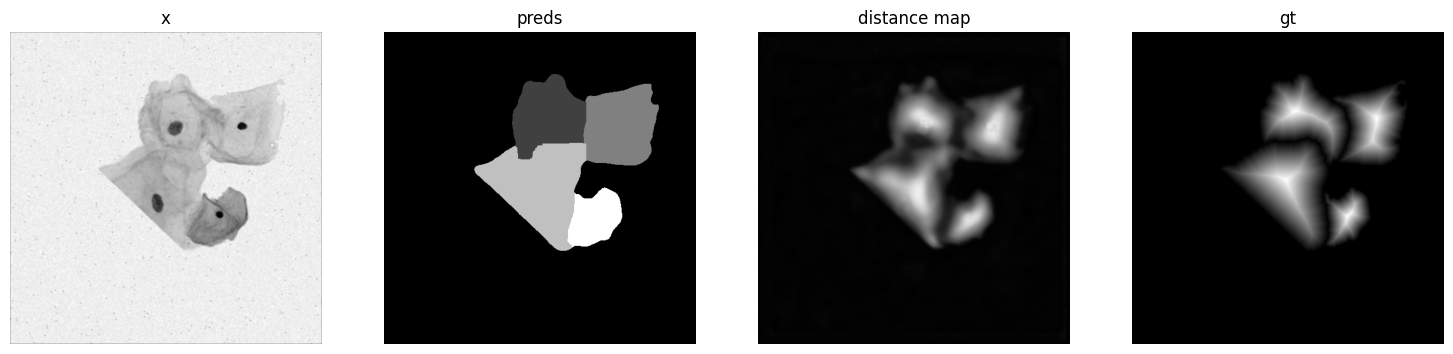

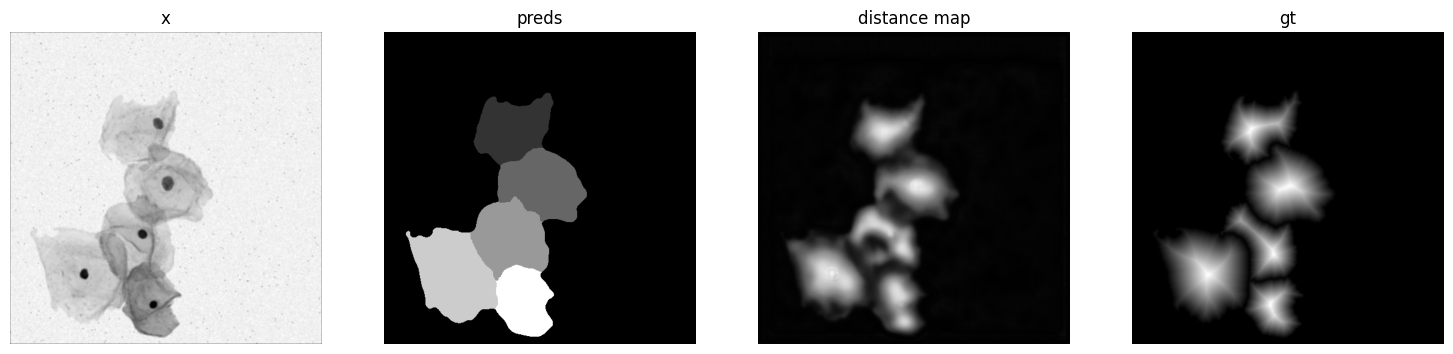

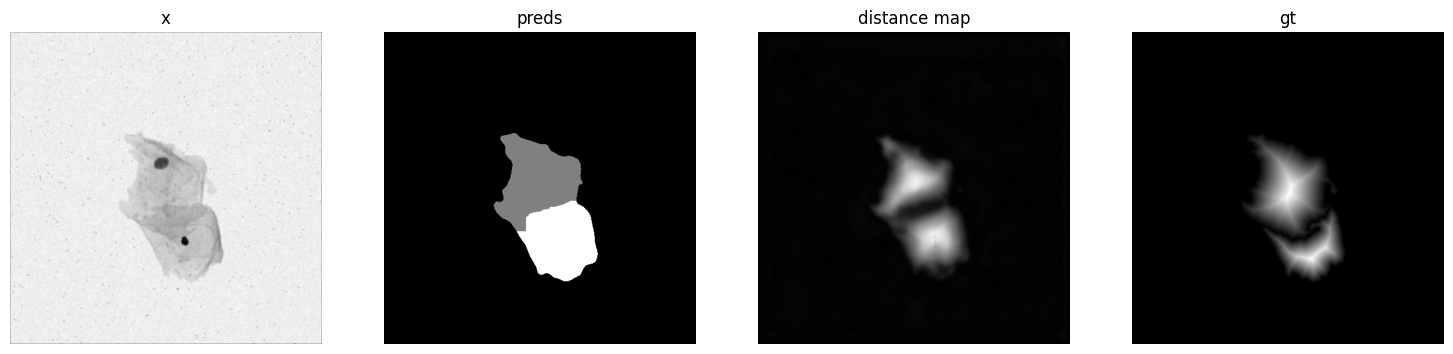

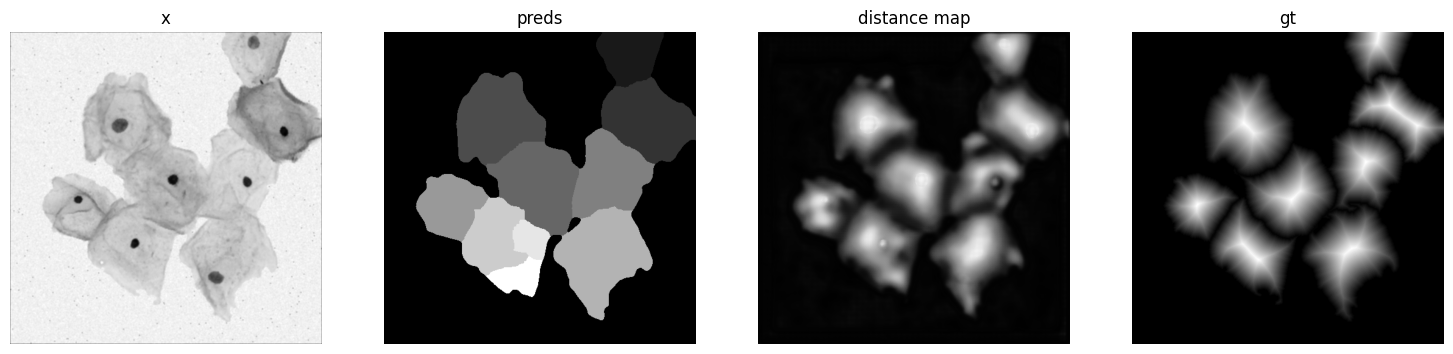

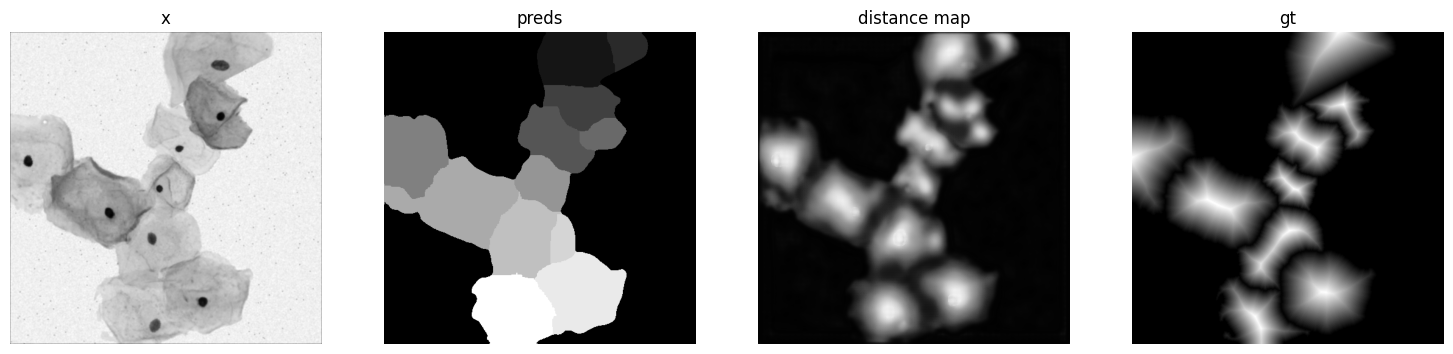

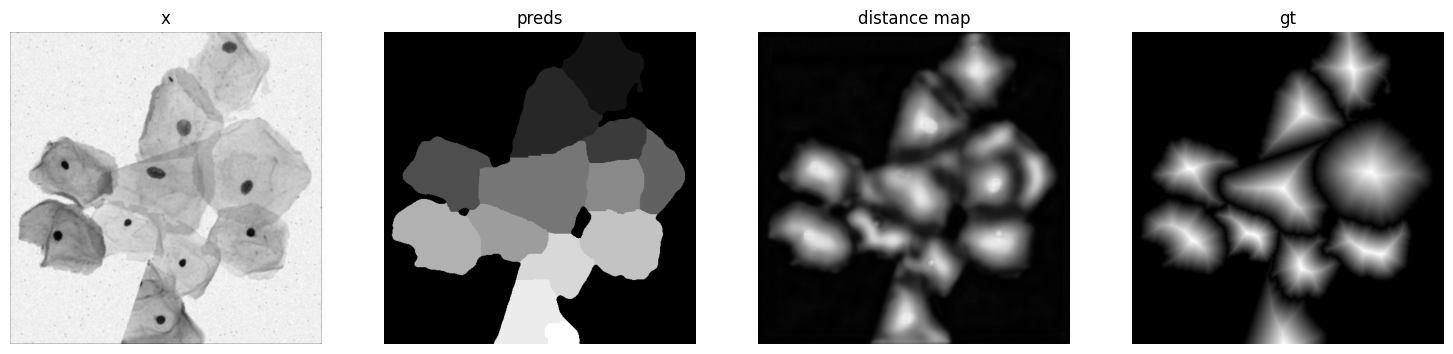

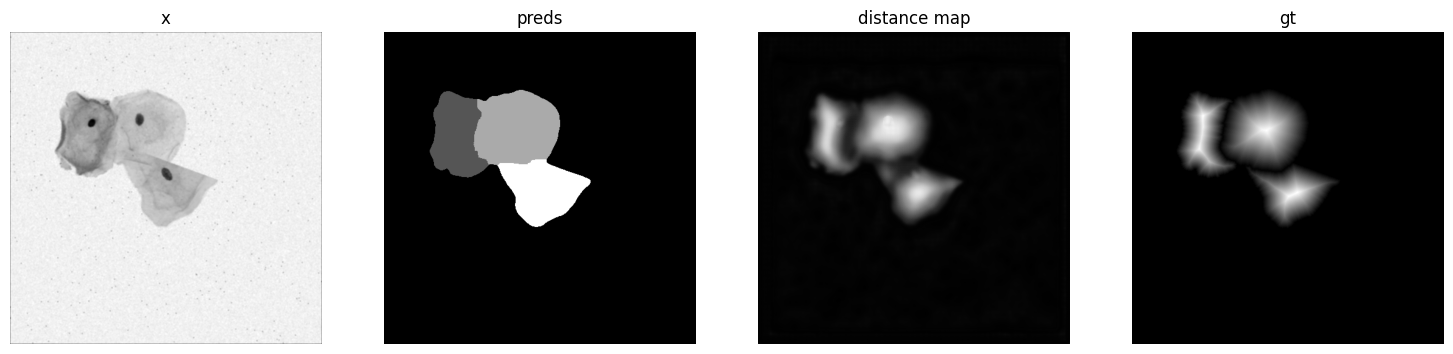

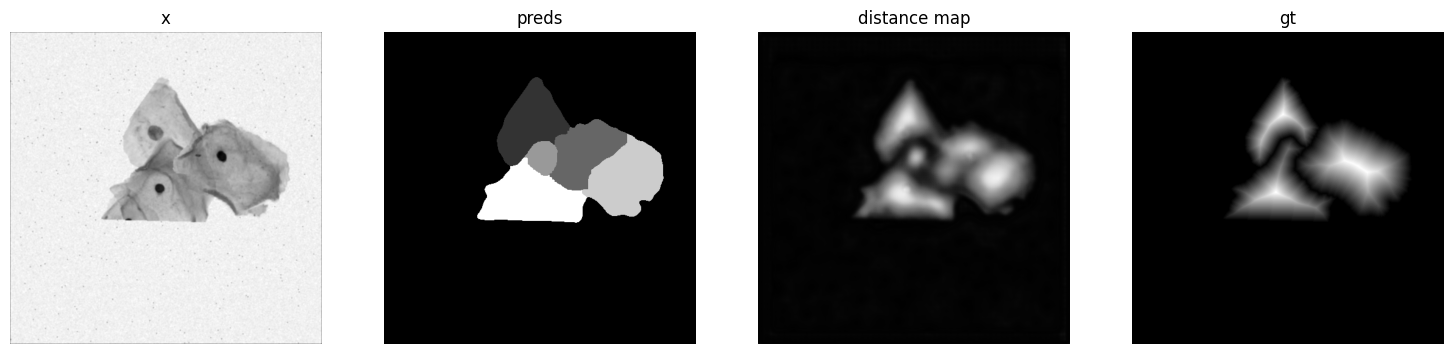

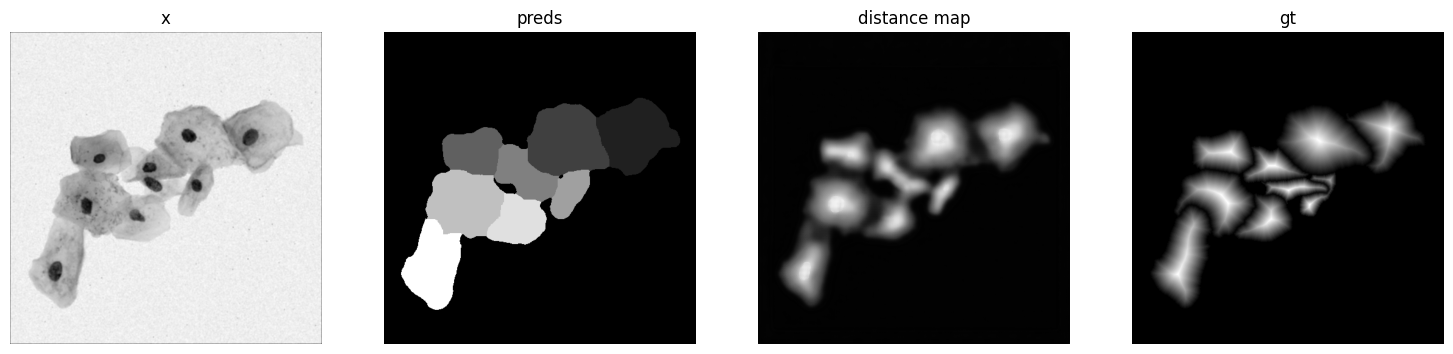

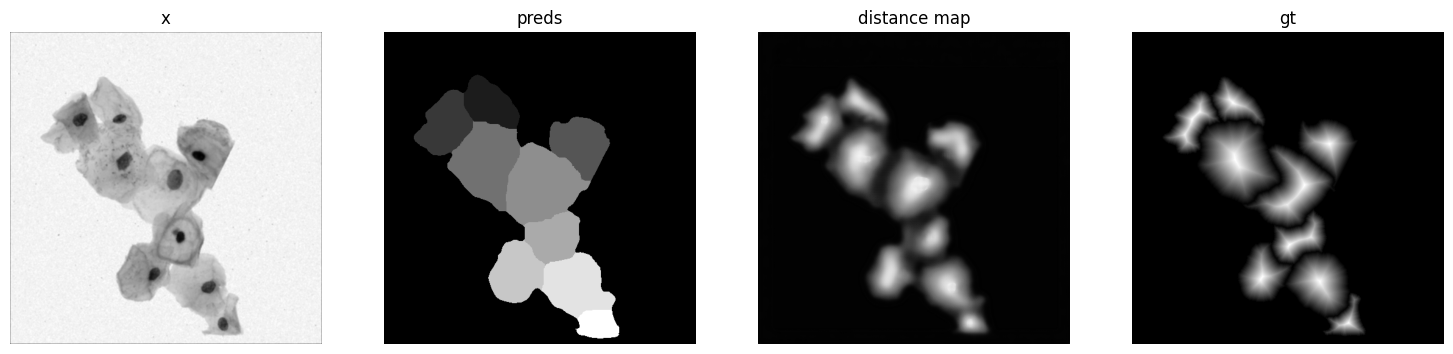

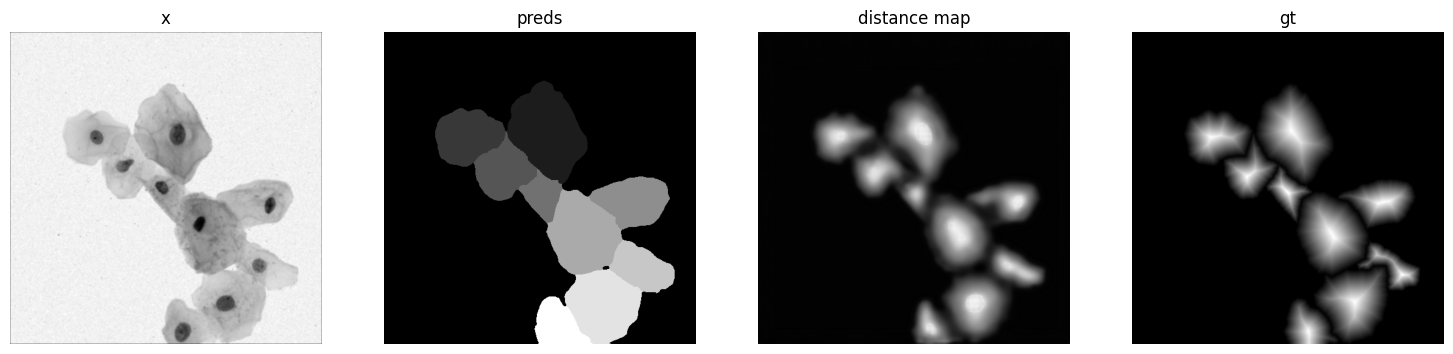

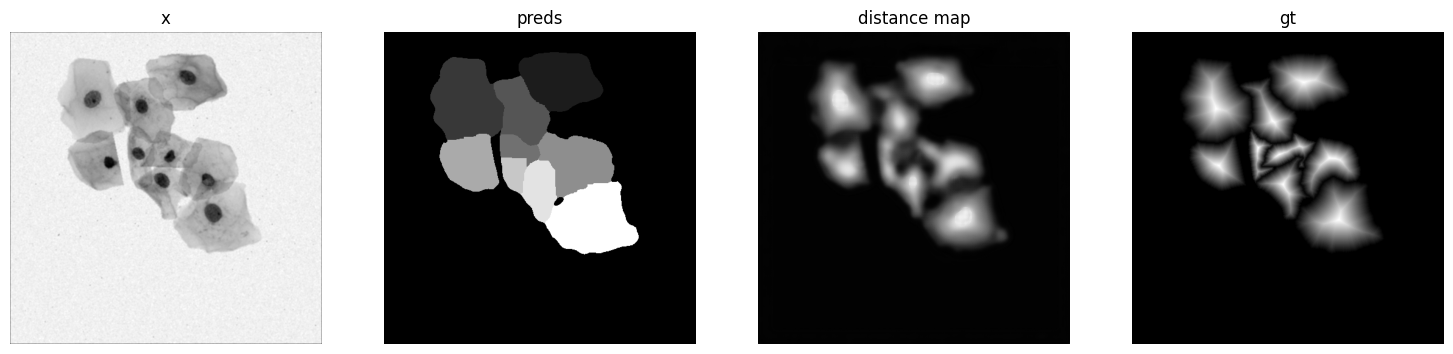

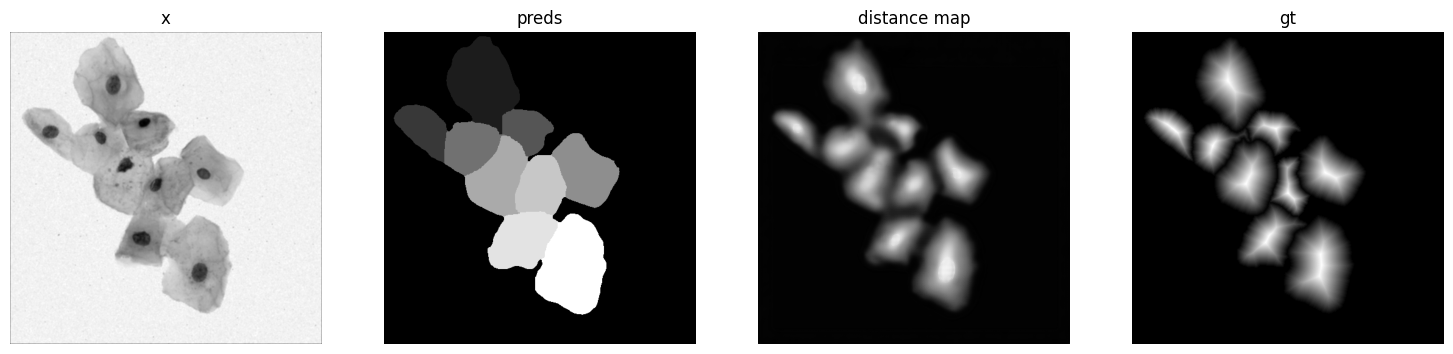

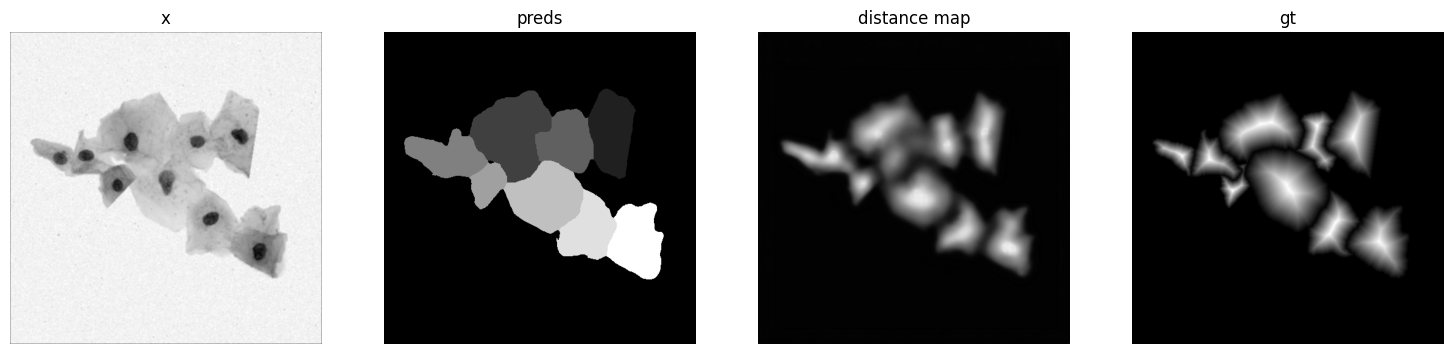

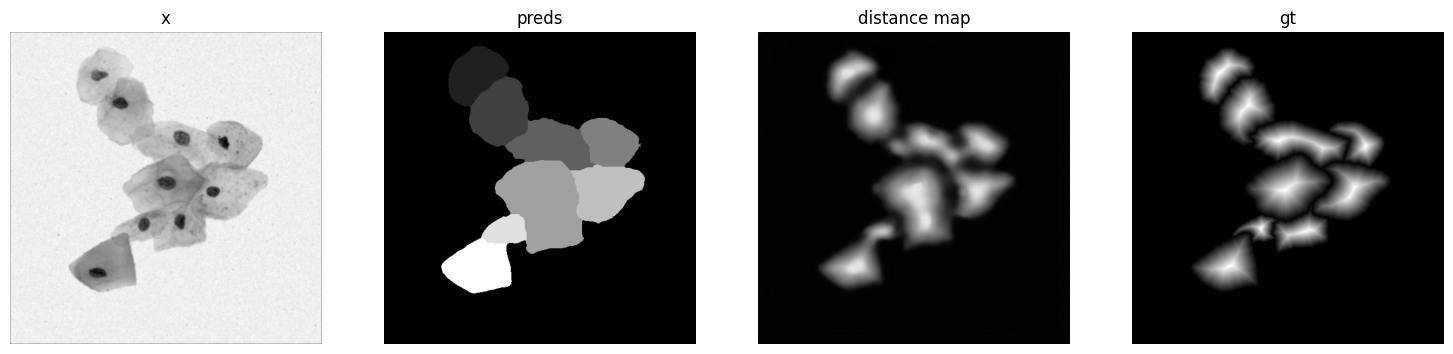

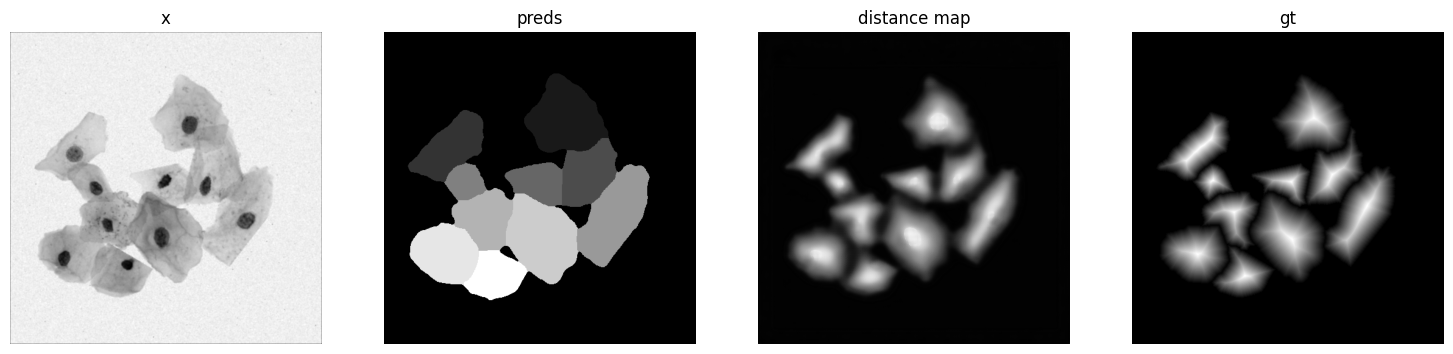

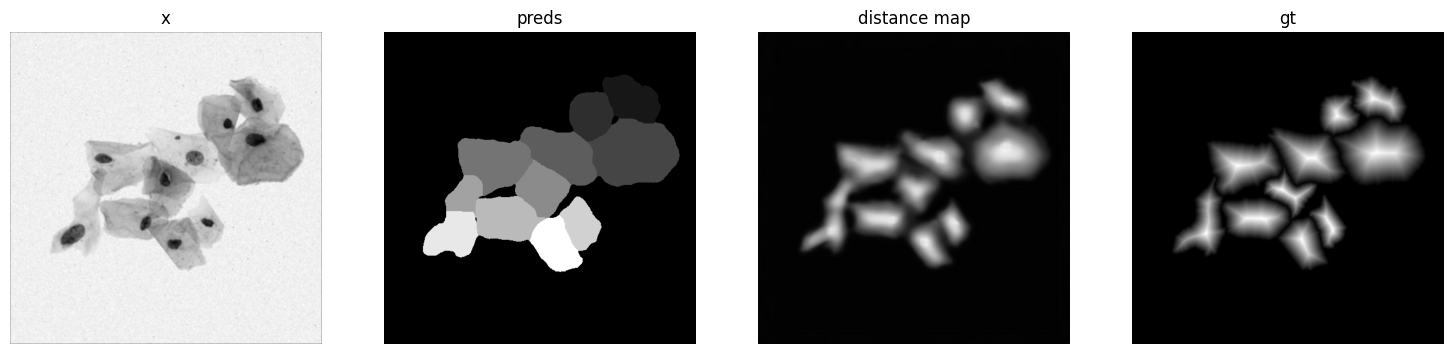

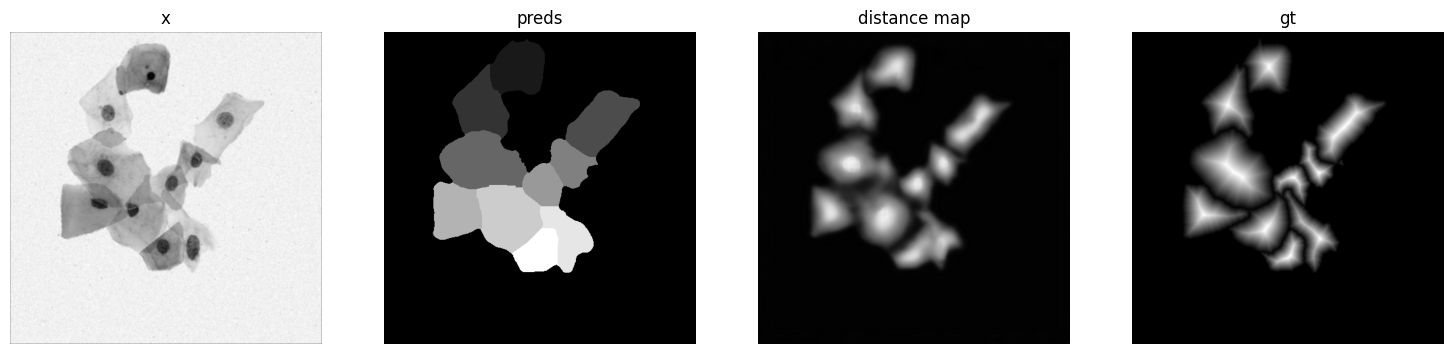

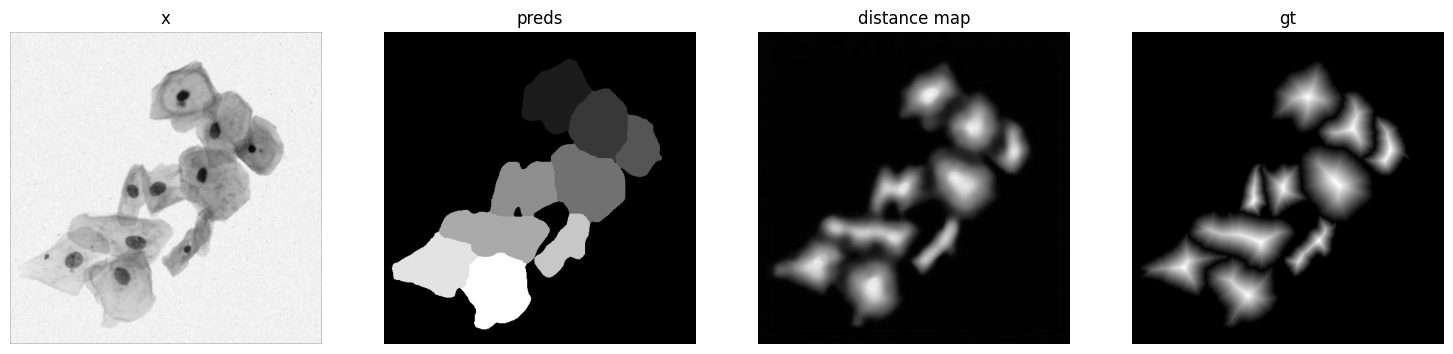

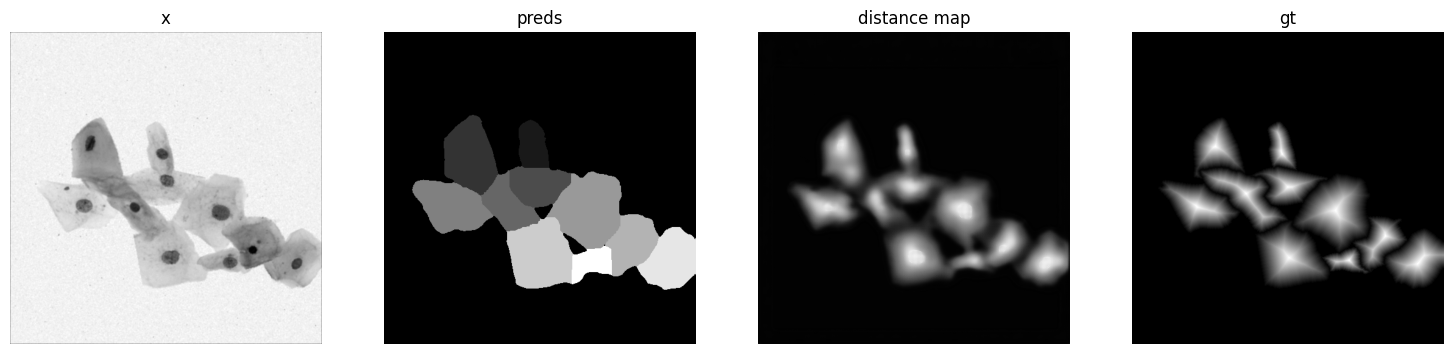

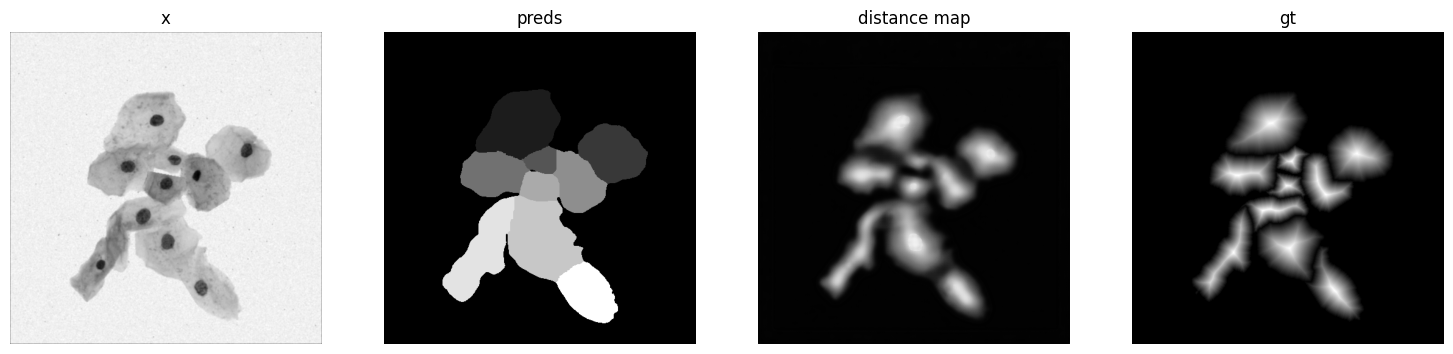

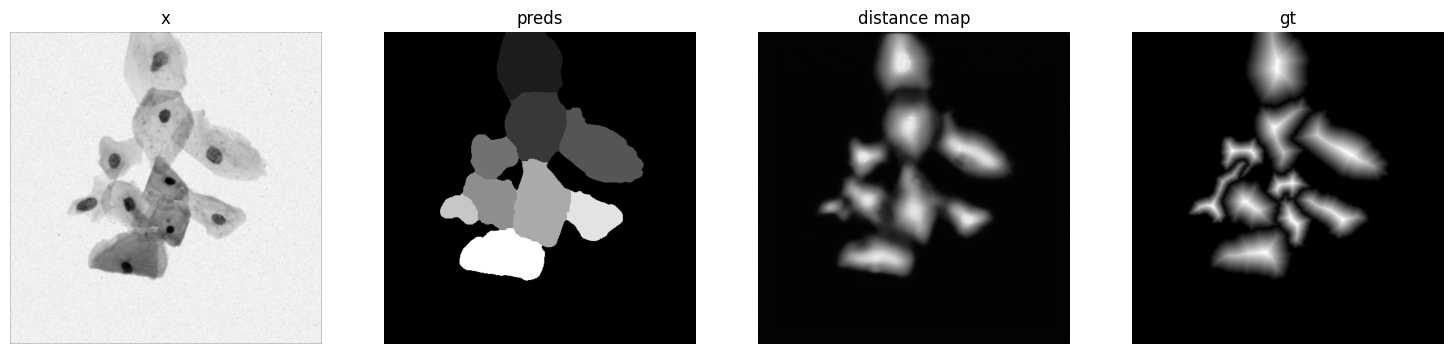

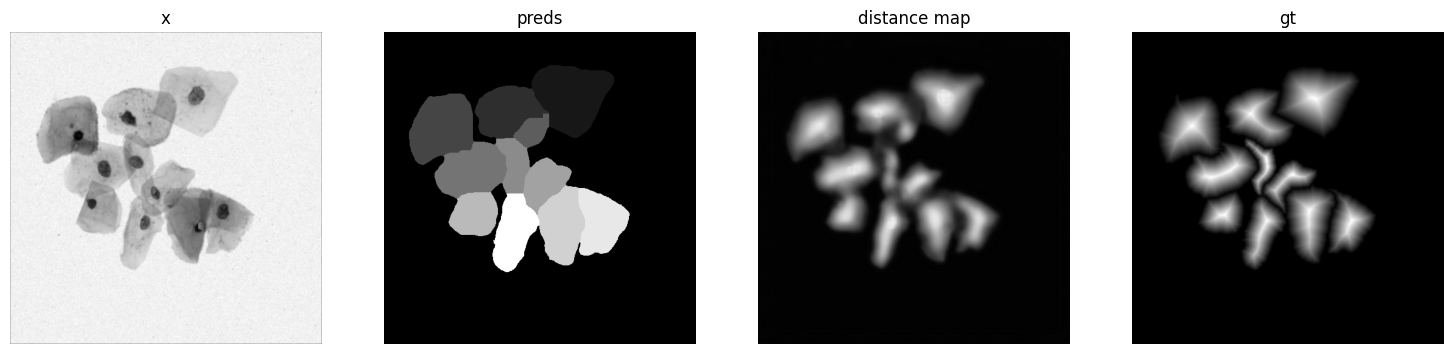

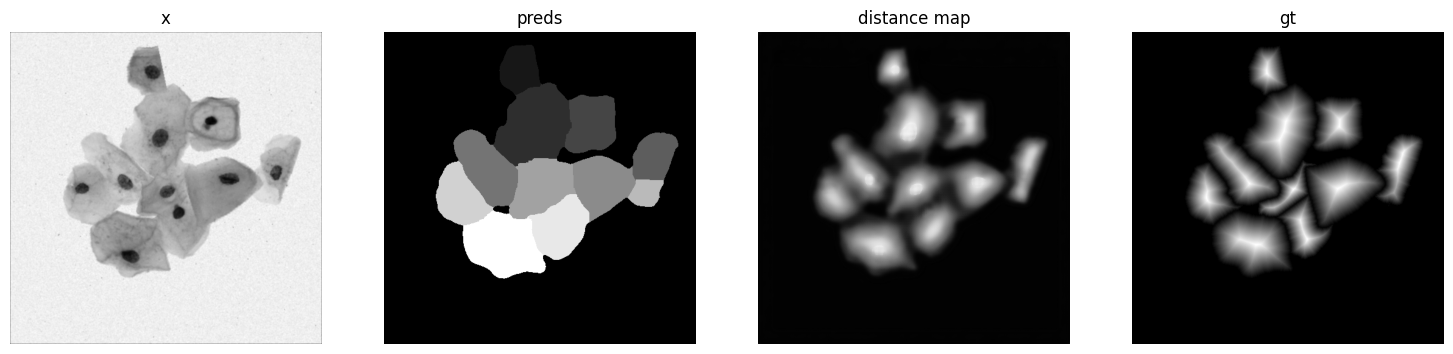

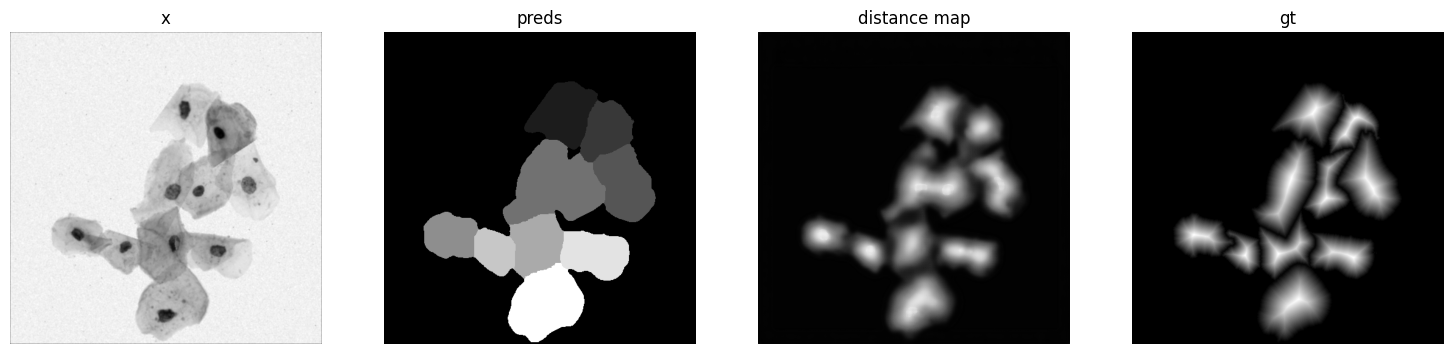

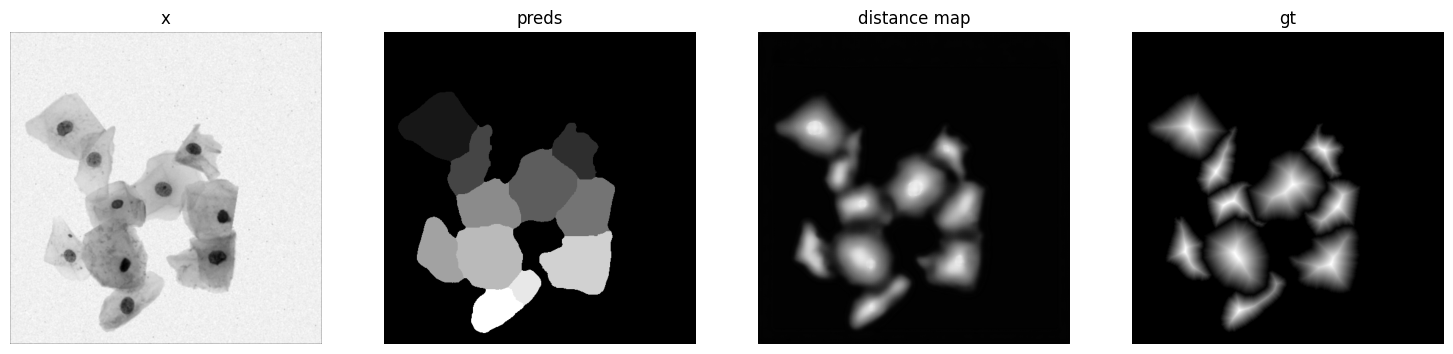

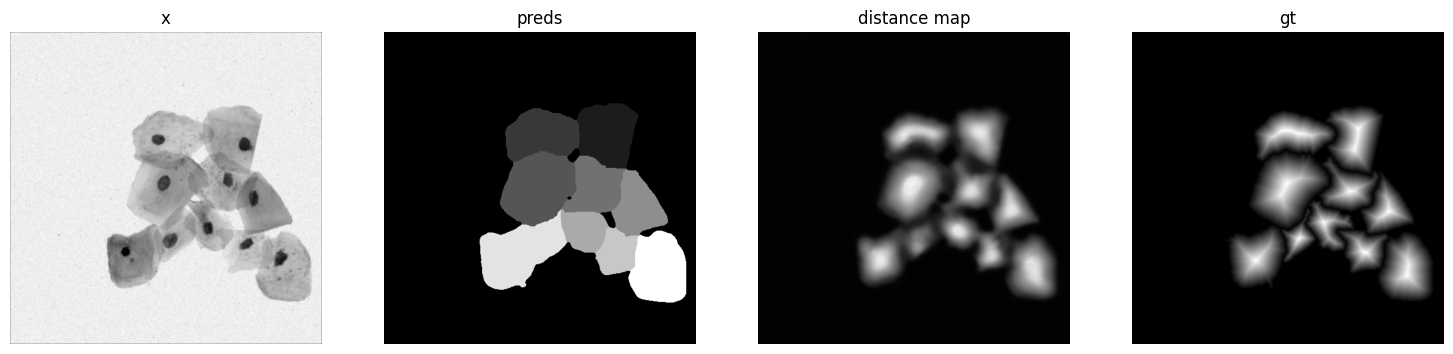

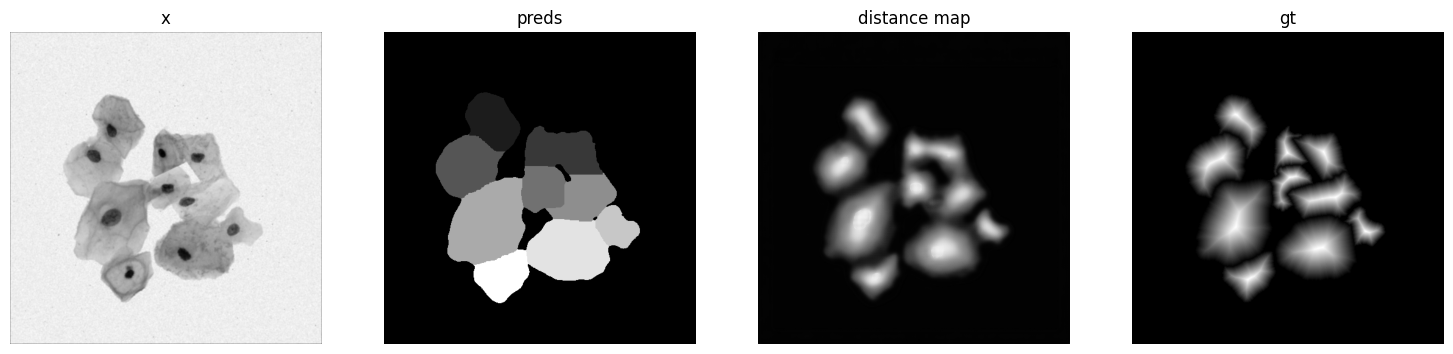

In [4]:
for k in range(len(x)):
    masks_summed = post_pro.process(y_pred[k].detach().cpu().numpy(),None)
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4)
    fig.set_size_inches(18.5, 10.5)
    
    ax1.imshow(x[k].permute(1,2,0),cmap='gray')
    ax1.set_title('x')
    ax1.axis('off')
    
    ax2.imshow(masks_summed*(255/np.max(masks_summed)).astype(np.uint8), cmap='gray')
    ax2.set_title('preds')
    ax2.axis('off')
    
    ax3.imshow(y_pred[k].detach().cpu().numpy(), cmap='gray')
    ax3.set_title('distance map')
    ax3.axis('off')
    
    ax4.imshow((y_true[k].detach().cpu().numpy()*(255/np.max(y_true[k].detach().cpu().numpy()))), cmap='gray')
    ax4.set_title('gt')
    ax4.axis('off')
    #plt.savefig(f'eval_unet/{k}.png',bbox_inches='tight', pad_inches=0)
    #plt.close()
    plt.show()